## 1) Installing Dependencies

In [46]:
# essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

# linear model
from sklearn.linear_model import LinearRegression

# ensemble models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor

# neural networks
from sklearn.neural_network import MLPRegressor
from keras import models, layers, optimizers, losses, metrics, Sequential


# Models


We will compare the following models:
1. `LinearRegression` as our base model
2. `RandomForestRegressor`
3. `XGBRegressor`
4. `HistGradientBoostingRegressor`
5. `MLPRegressor`
6. `Keras`


In [3]:
concrete = pd.read_csv('data/concrete.csv')
co2 = pd.read_csv('data/co2.csv')

concrete['exp_age'] = np.exp(-.038 * concrete['age'])

concrete['co2_lower'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'lower_bound'].values[0] for col in concrete.columns[:7]])
concrete['co2_upper'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'upper_bound'].values[0] for col in concrete.columns[:7]])

concrete = concrete[concrete['age'] < 120]

concrete_train, concrete_test = train_test_split(concrete,
                                                 shuffle=True,
                                                 random_state=487)

features = ['cement', 'ash', 'slag', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']

In [4]:
# This function was modified from stackexchange user hughdbrown 
# at this link, 
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

# This returns the power set of a set minus the empty set
def powerset(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
        
    return power_set[1:]


## Linear Model

In [24]:
# for future use, this function gets mean squared error without constantly copy-pasting

def get_slr_mses(data, features_list, y, n_splits=5, rs=97):
    # data is the dataframe
    # features_list is a list of all lists of features we wish to compare
    # eg [[], ['feature1'], ['feature1', 'feature2, 'feature5']]
    # if one list is [], then we make a baseline prediction
    # y is the y feature we are predicting
    # k is the number of cross-validation splits
    # rs is the random_state for kfold
    kfold = KFold(n_splits,
              shuffle=True,
              random_state=rs)
    mses=np.zeros((n_splits, len(features_list)))

    i = 0
    # cross-validation
    for train_index, test_index in kfold.split(data):
        data_tt = data.iloc[train_index]
        data_ho = data.iloc[test_index]

        j = 0
        for features in features_list:
            if features == []:
                # baseline prediction
                pred = data_tt[y].values.mean() * np.ones(len(data_ho))
            else:
                reg = LinearRegression(copy_X=True)
                reg.fit(data_tt[features], data_tt[y])
                pred = reg.predict(data_ho[features])
            
            mses[i, j] = mean_squared_error(y_true=data_ho[y],
                                            y_pred=pred)
            j += 1
        
        i += 1

    return np.mean(mses, axis=0)



We attempt to improve the linear model a little by picking the exponential factor with all features in consideration

In [17]:
features2 = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'exp_age']


In [19]:
features2 = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'exp_age']

for factor in np.arange(.01, .1, .01):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    print(factor, np.min(get_slr_mses(concrete_train, powerset(features2), 'strength')))

0.01 57.70330104192804
0.02 51.14081744397187
0.03 47.781495017706575
0.04 47.158922486225194
0.05 48.18470524244171
0.060000000000000005 50.0325012084111
0.06999999999999999 52.172666716534025
0.08 54.32070776381877
0.09 56.351408732591054


In [18]:
best_mses = []

for factor in np.arange(.03, .05, .001):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    best_mses.append(np.min(get_slr_mses(concrete_train, powerset(features2), 'strength')))


print(np.arange(.03, .05, .001)[np.argmin(best_mses)], np.min(best_mses))

0.038000000000000006 47.11634037831618


## Random Forest

In [152]:
max_depths = [45]
features = ['cement', 'slag', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']
n_trees = [100, 200, 300]
n_jobs = [1]
max_features = [None]


grid_cv = GridSearchCV(RandomForestRegressor(), 
                          param_grid = {'max_depth':max_depths, 
                                        'n_estimators':n_trees,
                                        'n_jobs': n_jobs,
                                        'max_features': max_features}, 
                          scoring = 'neg_mean_squared_error', 
                          cv = 5) 

## you fit it just like a model
grid_cv.fit(concrete_train[features], concrete_train['strength'])

print(grid_cv.best_params_)
print(-grid_cv.best_score_)

{'max_depth': 45, 'max_features': None, 'n_estimators': 200, 'n_jobs': 1}
29.750892287963836


In [153]:
max_depths = np.arange(40, 51, 1)
features = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age', 'exp_age']
n_trees = [100, 500]

grid_cv = GridSearchCV(RandomForestRegressor(), 
                          param_grid = {'max_depth':max_depths, 
                                        'n_estimators':n_trees}, 
                          scoring = 'neg_mean_squared_error',
                          cv = 5) 

## you fit it just like a model
grid_cv.fit(concrete_train[features], concrete_train['strength'])

print(grid_cv.best_params_)
print(-grid_cv.best_score_)

{'max_depth': 46, 'n_estimators': 100}
29.206099330106305


## XGBoost

In [6]:
def xg_grid(max_depths,features,n_trees,concrete_train, tree_methods, print_best=True):

    grid_cv = GridSearchCV(XGBRegressor(),
                              param_grid = {'max_depth':max_depths, 
                                            'n_estimators':n_trees,
                                            'tree_method': tree_methods}, 
                              scoring = 'neg_mean_squared_error', 
                              cv = 5) 

    ## you fit it just like a model
    grid_cv.fit(concrete_train[features], concrete_train['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv

In [7]:
max_depths = [2]
features = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age']
n_trees = [1200]
tree_methods = ['approx']

xg_grid(max_depths,features,n_trees,concrete_train, tree_methods, print_best=True)

The best set of parameters is {'max_depth': 2, 'n_estimators': 1200, 'tree_method': 'approx'}
The best set of score is 19.640115527493624


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': [2], 'n_estimators': [1200],
                         'tree_method': ['approx']},
             scoring='neg_mean_squared_error')

In [ ]:
max_depths = np.arange(2, 11)
n_trees = np.arange(1000, 2000, 10)
tree_methods = ['approx', 'hist', 'gpu_hist']

best_mses = []
best_xgb_params = []

for feature in powerset(features):
    grid_cv = xg_grid(max_depths,feature,n_trees,concrete_train, tree_methods, print_best=False)
    best_mses.append(grid_cv.best_score_)
    best_xgb_params.append(grid_cv.best_params_)


print(best_xgb_params[np.argmax(best_mses)], -np.max(best_mses))


{'max_depth': 2, 'n_estimators': 1200, 'tree_method': 'approx'} -305.54186741168775


In [186]:

print(best_params[np.argmax(best_mses)], -np.max(best_mses))

powerset(features)[np.argmax(best_mses)]

{'max_depth': 2, 'n_estimators': 1200, 'tree_method': 'approx'} 19.640115527493624


['cement',
 'slag',
 'ash',
 'water',
 'superplastic',
 'coarseagg',
 'fineagg',
 'exp_age']

In [182]:
n_trees = np.arange(100, 2001, 100)
mses = - xg_grid([2],features,n_trees,concrete_train, ['approx'], print_best=True).cv_results_['mean_test_score']
mses



The best set of parameters is {'max_depth': 2, 'n_estimators': 1200, 'tree_method': 'approx'}
The best set of score is 19.640115527493624


array([27.68878049, 23.16157797, 21.66978768, 20.69625276, 20.3404631 ,
       20.12452399, 19.89260176, 19.66982308, 19.72231138, 19.64968767,
       19.67317779, 19.64011553, 19.64603412, 19.68432869, 19.65423094,
       19.71524728, 19.73650807, 19.76519029, 19.83415522, 19.87897323])

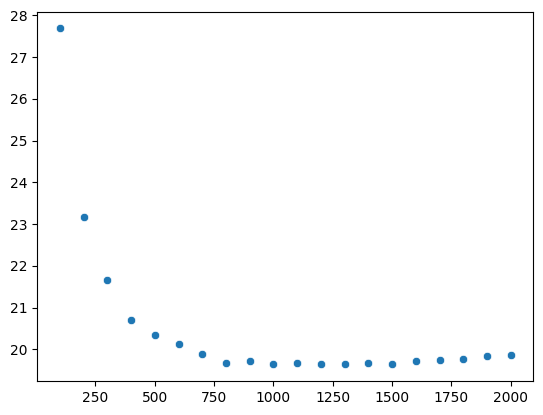

In [183]:
sns.scatterplot(x=n_trees,
y=mses)

plt.show()

## Histogram-based Gradient Boosting

In [8]:
def hgb_grid(max_depths,features,max_iters,concrete_train, learning_rates, print_best=True):

    grid_cv = GridSearchCV(HistGradientBoostingRegressor(),
                              param_grid = {'max_depth':max_depths, 
                                            'max_iter':max_iters,
                                            'learning_rate': learning_rates}, 
                              scoring = 'neg_mean_squared_error', 
                              cv = 5) 

    ## you fit it just like a model
    grid_cv.fit(concrete_train[features], concrete_train['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv

In [12]:
np.arange(2, 10)

array([2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
max_depths = np.arange(2, 10)
max_iters = np.arange(200, 1000, 10)
learning_rates = np.arange(.05, .15, .01)

best_mses = []
best_hgb_params = []

for feature in powerset(features):
    grid_cv = hgb_grid(max_depths,features,max_iters,concrete_train, learning_rates, print_best=False)
    best_mses.append(grid_cv.best_score_)
    best_hgb_params.append(grid_cv.best_params_)


print(best_hgb_params[np.argmax(best_mses)], -np.max(best_mses))


In [198]:
max_depths = np.arange(1, 11)
mses = - hgb_grid(max_depths,features,[800],concrete_train, [.1], print_best=True).cv_results_['mean_test_score']
mses

The best set of parameters is {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 800}
The best set of score is 21.90660451714236


array([34.21160879, 25.58425841, 24.41561855, 23.34262051, 21.90660452,
       23.18271334, 23.59941612, 23.81869135, 23.81494052, 23.9656131 ])

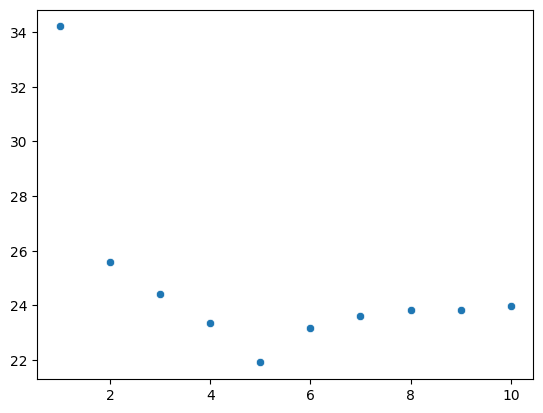

In [199]:
sns.scatterplot(x=max_depths,
y=mses)

plt.show()

This is the best I have gotten it, after much tinkering

## MLPRegressor

In [210]:
X_train, y_train = scale.fit_transform(concrete_train[features]), concrete_train['strength']

In [207]:
concrete_tt, concrete_val = train_test_split(concrete_train,
                                             shuffle=True,
                                             random_state=453)

X_tt, y_tt = scale.fit_transform(concrete_tt[features]), concrete_tt['strength']
X_val, y_val = scale.fit_transform(concrete_val[features]), concrete_val['strength']

In [9]:
def mlp_grid(hidden_layer_sizes,features,activations,concrete_train, learning_rates, solvers, print_best=True):

    scale = StandardScaler(copy=True)
    X_scale = scale.fit_transform(concrete_train[features])
    grid_cv = GridSearchCV(MLPRegressor(max_iter=10000), 
                          param_grid = {'hidden_layer_sizes': hidden_layer_sizes,
                                        'learning_rate': learning_rates,
                                        'solver': solvers,
                                        'activation': activations,
                                        }, 
                          scoring = 'neg_mean_squared_error', 
                          cv = 5) 

    grid_cv.fit(X_scale, concrete_train['strength'])

    if print_best:
        print(f'The best set of parameters is {grid_cv.best_params_}')
        print(f'The best set of score is {-grid_cv.best_score_}')

    return grid_cv

In [211]:
hidden_layer_sizes = [(100, 100)]
learning_rates = ['constant', 'adaptive']
solvers = ['lbfgs', 'sgd', ]
activations = ['relu', 'identity', 'logistic', 'tanh']
alphas = [.0001]

grid_cv = mlp_grid(hidden_layer_sizes,features,activations,concrete_train, learning_rates, solvers, print_best=True)

The best set of parameters is {'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'solver': 'sgd'}
The best set of score is 31.788966162807498


In [32]:
n_range = np.arange(120, 220, 5)
hidden_layer_sizes = [(n, n) for n in n_range]
learning_rates = ['adaptive']
solvers = ['sgd']
activations = ['relu']
alphas = [.0001]

mses = - mlp_grid(hidden_layer_sizes,features,activations,concrete_train, learning_rates, solvers, print_best=True).cv_results_['mean_test_score']


The best set of parameters is {'activation': 'relu', 'hidden_layer_sizes': (165, 165), 'learning_rate': 'adaptive', 'solver': 'sgd'}
The best set of score is 24.859101463511994


In [ ]:
hidden_layer_sizes = [(n, n) for n in np.arange(150, 210, 5)]
learning_rates = ['constant', 'adaptive']
solvers = ['lbfgs', 'sgd', 'adam']
activations = ['relu', 'identity', 'logistic', 'tanh']
alphas = [.0001]

mses = - mlp_grid(hidden_layer_sizes,features,activations,concrete_train, learning_rates, solvers, print_best=True).cv_results_['mean_test_score']


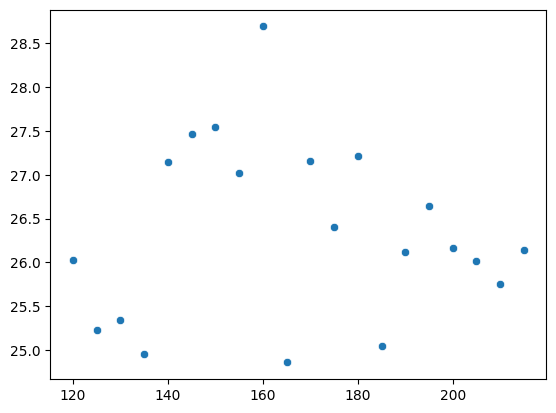

In [33]:

sns.scatterplot(x=n_range,
                y=mses)

plt.show()

## Keras Model

In [230]:
# Only scaling training data

n_splits = 5
kfold = KFold(n_splits=n_splits,
              shuffle=True,
              random_state=411)
scale = StandardScaler(copy=True)

X_train, y_train = scale.fit_transform(concrete_train[features]), concrete_train['strength']

n_epochs = 400
mses = np.zeros(n_splits)
best_epochs = np.zeros(n_splits)
i = 0
for train_index, test_index in kfold.split(concrete_train):



    X_tt, y_tt = X_train[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train[test_index], y_train.iloc[test_index]

    model1 = Sequential()
    model1.add(layers.Dense(150, activation='relu', input_shape=(X_tt.shape[1],)))
    model1.add(layers.Dense(100, activation='relu'))
    model1.add(layers.Dense(100, activation='relu'))
    model1.add(layers.Dense(100, activation='relu'))
    model1.add(layers.Dense(1, activation='relu'))

    model1.compile(optimizer = 'rmsprop',
                    loss = 'mean_squared_error',
                    metrics = ['mse'])
    history1 = model1.fit(X_tt,
                        y_tt,
                        epochs = n_epochs,
                        batch_size = 50,
                        # verbose=0,
                        validation_data = (X_ho, 
                                            y_ho))

    mses[i] = np.min(history1.history['val_mse'])
    best_epochs[i] = np.argmin(history1.history['val_mse'])


    i +=1

np.mean(mses)

Epoch 1/400
12/12 [==============================] - 3s 55ms/step - loss: 1177.7344 - mse: 1177.7344 - val_loss: 653.7554 - val_mse: 653.7554
Epoch 2/400
12/12 [==============================] - 0s 14ms/step - loss: 277.3828 - mse: 277.3828 - val_loss: 226.7487 - val_mse: 226.7487
Epoch 3/400
12/12 [==============================] - 0s 14ms/step - loss: 170.3129 - mse: 170.3129 - val_loss: 201.7657 - val_mse: 201.7657
Epoch 4/400
12/12 [==============================] - 0s 31ms/step - loss: 154.3048 - mse: 154.3048 - val_loss: 170.6984 - val_mse: 170.6984
Epoch 5/400
12/12 [==============================] - 0s 28ms/step - loss: 137.1324 - mse: 137.1324 - val_loss: 202.3536 - val_mse: 202.3536
Epoch 6/400
12/12 [==============================] - 0s 20ms/step - loss: 130.5164 - mse: 130.5164 - val_loss: 160.6778 - val_mse: 160.6778
Epoch 7/400
12/12 [==============================] - 0s 13ms/step - loss: 120.5772 - mse: 120.5772 - val_loss: 146.1408 - val_mse: 146.1408
Epoch 8/400
12/12 

29.65964279174805

In [8]:
features

['cement',
 'ash',
 'slag',
 'water',
 'superplastic',
 'coarseagg',
 'fineagg',
 'exp_age']

In [54]:

n_range = np.arange(50, 310, 50)
n_splits = 5

kfold = KFold(n_splits=n_splits,
              shuffle=True,
              random_state=409)
scale = StandardScaler(copy=True)

n_epochs = 400
keras_mses = np.zeros((n_splits, len(n_range)))
best_epochs = np.zeros((n_splits, len(n_range)))
i = 0
for train_index, test_index in kfold.split(concrete_train):

    concrete_tt, concrete_ho = concrete_train.iloc[train_index], concrete_train.iloc[test_index]

    X_tt, y_tt = scale.fit_transform(concrete_tt[features]), concrete_tt['strength']
    X_ho, y_ho = scale.fit_transform(concrete_ho[features]), concrete_ho['strength']
    j = 0
    for n in n_range:
        print(j)
        model1 = Sequential()
        model1.add(layers.Dense(n, activation='relu', input_shape=(X_tt.shape[1],)))
        model1.add(layers.Dense(n, activation='relu'))
        model1.add(layers.Dense(n, activation='relu'))
        model1.add(layers.Dense(n, activation='relu'))
        model1.add(layers.Dense(1, activation='relu'))

        model1.compile(optimizer = 'rmsprop',
                        loss = 'mean_squared_error',
                        metrics = ['mse'])
        history1 = model1.fit(X_tt,
                            y_tt,
                            epochs = n_epochs,
                            batch_size = 50,
                            verbose=0,
                            validation_data = (X_ho, 
                                                y_ho))

        keras_mses[i, j] = np.min(history1.history['val_mse'])
        best_epochs[i, j] = np.argmin(history1.history['val_mse'])
        j += 1
    
    i += 1

np.mean(keras_mses, 0)

0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5


array([310.24919739,  27.11318283,  25.07059288, 317.39542046,
        26.73327141,  26.21896706])

In [10]:
best_epochs

array([384., 349., 261., 348., 396.])

In [51]:
keras_mses

array([25.23081779, 18.6203022 , 29.45568848, 26.09188843, 29.358675  ])